In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Discovering and forecasting extreme events via active learning in neural operators

Citation - Pickering, E., Guth, S., Karniadakis, G. E. & Sapsis, T. P. Discovering and forecasting extreme events via active learning in neural operators. Nat Comput Sci 2, 823–833 (2022).

## 3) Efficient Estimation of Structural Fatigue for Ship Design

* The LAMP-based problem aims to efficiently estimate the VBM (vertical bending moment) statistics of a unique ship, the ONR topsides flare variant, to inform future design decisions. 
* This real-life industrial application brings significant complexity and numerous challenges. 
* These are documented at length in Guth and Sapsis (2022) [9] and we strongly refer the reader to the above paper as we closely follow their implementation. 
* Briefly, we describe the inputs and outputs below. Similar to the previous problems, we parametrize a low-dimensional projected subspace of wave episodes using a Karhunen Loève series expansion [10, 11] of the stochastic surface waves, described by a power spectral density such as the JONSWAP spectrum. 
* We next use the proprietary code LAMP (Large Amplitude Motion Program, v4.0.9, May 2019) [12] in order to calculate the forward problem of specific VBM response to a specific wave episode. 
* A specific wave episode, described by the parametrization x, is mapped onto a VBM time series y(t), whose duration is related to the original interval of the Karhunen Loève expansion. 
* Finally, as the LAMP code is proprietary and cannot be shared, we perform our active search in a precomputed dataset of 3000 (expensive simulations) LHS samples in 10D, with each input variable varying from [−4.5, 4.5]. 
* This data is provided with the code.


In [2]:
# Imports
import utils.lamp_helper_functions as hf
from utils.gaussian_input import GaussianInputs
import scipy.io as sio

# Variables 

seed                = 3 # Seed for initial condition consistency - NOTE due to gradient descent of the DNO, the seed will not provide perfectly similar results, but will be analogous
initial_iter_num    = 0 # Iteration number
dim                 = 10 # Dimension of the KL subspace
acq                 = 'KUS_LW' # Acquisition type - currently only Likelihood-weighted uncertatiny sampling
n_init              = 3 # Initial data points
epochs              = 1000  # Number of training epochs
b_layers            = 8 # Branch Layers
t_layers            = 1 # Trunk Layers
neurons             = 300 # Number of neurons per layer
init_method         = 'pdf'# How initial data are pulled
N                   = 2 # Number of DNO ensembles
iters_max           = 2  # Iterations to perform
run_name            = 'temp'
activation_func     = 'relu'
sampling_sigma      = 0

# Dim stuff

ndim = dim
udim = dim # The dimensionality of the U components of Theta

# DeepONet only needs a coarse version of the signal    
coarse = 4

u_decimation_factor = 5
y_decimation_factor = 2

#
as_target_quantity = 'mode-coefficient'
#as_target_quantity = 'vbm-interval-extrema'


np.random.seed(seed)

In [3]:
# Path for creating/loading directories
data_path = './LAMP_10D_Data/'
gpr_pdf_path = './LAMP_10D_Data/'

output_path = './{}/'.format(run_name)
err_save_path = '{}errors/'.format(output_path)
model_dir =  '{}'.format(output_path)
intermediate_data_dir =  '{}data/'.format(output_path)
as_dir = '{}as_quantities/'.format(output_path)
fig_save_path = '{}plots/'.format(output_path)

model_suffix = '-{}-40'.format(dim)

In [4]:
# Make Directories
hf.make_dirs(output_path, err_save_path, model_dir, as_dir, fig_save_path, intermediate_data_dir)

[Errno 17] File exists: './temp/'
[Errno 17] File exists: './temp/errors/'
[Errno 17] File exists: './temp/'
[Errno 17] File exists: './temp//model'
[Errno 17] File exists: './temp/as_quantities/'
[Errno 17] File exists: './temp/plots/'
[Errno 17] File exists: './temp/data/'


In [5]:
# Load data from .txt files

wTT, wDD, wVV = hf.load_wave_data(data_path, model_suffix)
vTTlhs, vZZlhs, vAAlhs = hf.load_vbm_lhs_data(data_path, model_suffix, trim=False)
#vTTmc, vZZmc, vAAmc = hf.load_vbm_mc_data(data_path, model_suffix)
vTTmc, vZZmc, vAAmc = hf.load_vbm_lhs_data(data_path, model_suffix,  trim=False)
qq_xx, qq_pp, mm_xx, mm_pp = hf.load_gpr_precomputed(gpr_pdf_path, dim)
#sigma_n_filename = '{}{}-40-sigma-n-list.txt'.format(gpr_pdf_path, dim)
#sigma_n_list = np.loadtxt(sigma_n_filename)
n_lhs_data = vAAlhs.shape[0]
n_wave_t = wTT.shape[0]
#n_vbm_t = vZZlhs.shape[1]

vAAlhs = vAAlhs[:, 0:dim]

In [6]:
# Data Paths
save_suffix = 'Seed_'+str(seed)+'_N'+str(N)+'_iter_'+str(initial_iter_num)+'.mat'
load_suffix = 'Seed_'+str(seed)+'_N'+str(N)+'_iter_'+str(initial_iter_num-1)+'.mat'

save_path_data = '{}LAMP_{}'.format(intermediate_data_dir, save_suffix)
load_path_data = '{}LAMP_{}'.format(intermediate_data_dir, load_suffix)

save_error_data = '{}LAMP_Errors_{}'.format(err_save_path, save_suffix)
load_error_data = '{}LAMP_Errors_{}'.format(err_save_path, load_suffix)

#
# Number of output modes to retain, and how many to use in the RR rondel
# Roughly, n_q_modes ought be between 2 and 3 times dim, and rr_constant
# ought be between 1 and 1.5 times dim
#
# If this gets too big, we run into memory problem w.r.t. how many NN we
# need to store in memory (per round) simultaneously
#

n_q_modes = np.minimum(2*dim+2, 10)
rr_constant = np.minimum(1*dim+2, 6)


In [7]:
# PCA transform of VBM!    
QQ, w_vbm, v_vbm, vv_var = hf.pca_transform_z_2_q(vZZlhs, vZZmc, sklearn_pca_algo = False, n_q_modes=n_q_modes)

#
# Set up the input space
#
    
mean, cov = np.zeros(ndim), np.ones(ndim)
zstar = 4.5
domain = [ [-zstar, zstar] ] * ndim
inputs = GaussianInputs(domain, mean, cov)

In [8]:
#
# Initialize data matrices
#

if initial_iter_num == 0 :
    #
    # Draw the initial data points
    # 
    ii_pick = np.random.randint(0, high=n_lhs_data-1, size=n_init)
    Theta = vAAlhs[ii_pick, :]
    Y = QQ[ii_pick, :]
    
    # Keeping track of the error metric
    pys = np.zeros((iters_max, qq_xx.shape[0]))
    log10_errors_mode = np.zeros((iters_max, n_q_modes))
    log10_errors_vbm = np.zeros((iters_max, 1))
    log10_errors_vbm2 = np.zeros((iters_max, 1))
    
else :
    #
    # Load current AS state from saved data
    # (Only get here if you launch from Bash and this isn't the first iterate)
    #
    d = sio.loadmat(load_path_data)
    Theta = d['Theta']
    Y = d['Y']
    
    #
    # Load previosu error metrics!
    #
    
    previous_pys = d['pys']
    pys = np.zeros((previous_pys.shape[0]+1, qq_xx.shape[0]))
    pys[0:-1, :] = previous_pys
    
    d = sio.loadmat(load_error_data)
    previous_mode_err = d['log10_errors_mode']
    log10_errors_mode = np.zeros((previous_mode_err.shape[0]+1, n_q_modes))
    log10_errors_mode[0:-1, :] = previous_mode_err[:, :]
    
    previous_vbm_err = d['log10_errors_vbm']
    log10_errors_vbm = np.zeros((previous_vbm_err.shape[0]+1, 1))
    log10_errors_vbm[0:-1, 0] = previous_vbm_err[:, 0]
    
    previous_vbm_err2 = d['log10_errors_vbm2']
    log10_errors_vbm2 = np.zeros((previous_vbm_err2.shape[0]+1, 1))
    log10_errors_vbm2[0:-1, 0] = previous_vbm_err2[:, 0]

In [9]:
import deepxde as dde

m       = int(n_wave_t/coarse)
print(f"m:{m}")
lr      = 0.001
dim_x   = 1
#activation = "relu"
#activation  = "tanh"
activation  = activation_func        # Read this in from runner
branch      = [neurons]*(b_layers+1)
branch[0]   = m
trunk       = [neurons]*(t_layers+1)
trunk[0]    = dim_x

net = dde.maps.DeepONet(
    branch,
    trunk,
    activation,
    "Glorot normal",
    # use_bias=True,
    # stacked=False,
)
print(net)
save_period = 1000
print(n_wave_t)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


m:256
DeepONet(
  (branch): FNN(
    (linears): ModuleList(
      (0): Linear(in_features=256, out_features=300, bias=True)
      (1-7): 7 x Linear(in_features=300, out_features=300, bias=True)
    )
  )
  (trunk): FNN(
    (linears): ModuleList(
      (0): Linear(in_features=1, out_features=300, bias=True)
    )
  )
  (b): ParameterList(  (0): Parameter containing: [torch.float32 of size ])
)
1024


cur_mode:0/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


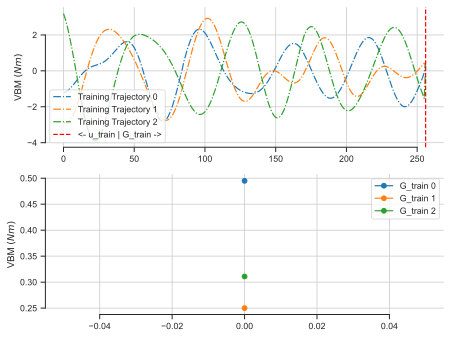

cur_mode:1/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


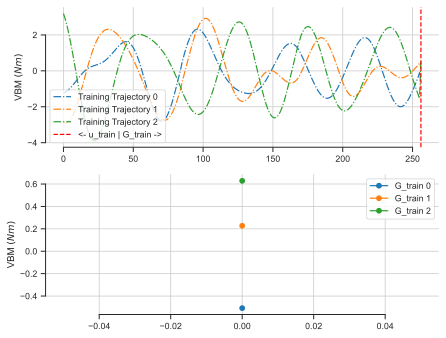

cur_mode:2/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


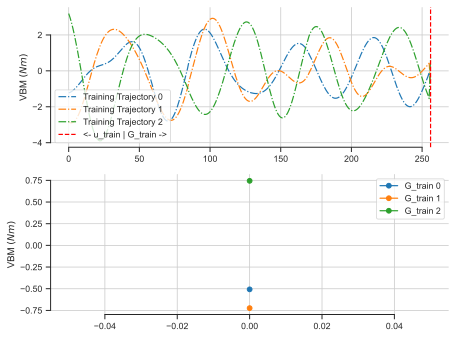

cur_mode:3/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


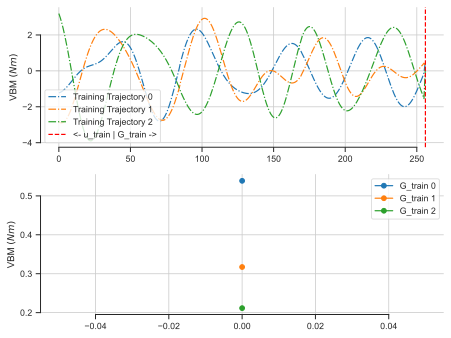

cur_mode:4/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


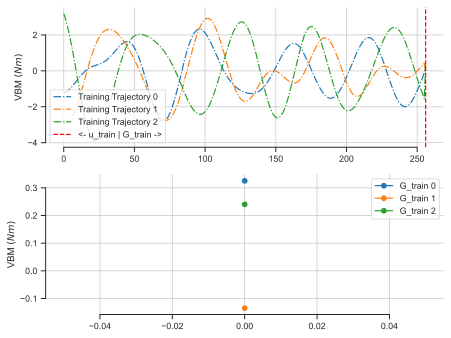

cur_mode:5/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


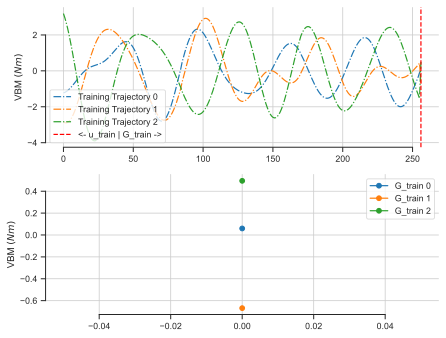

cur_mode:6/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


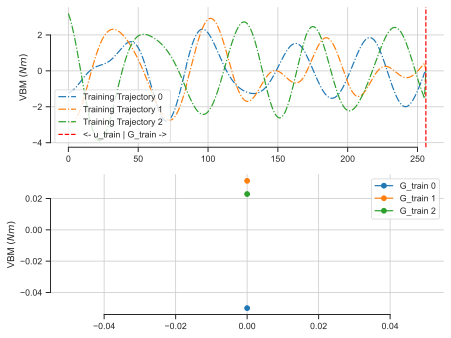

cur_mode:7/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


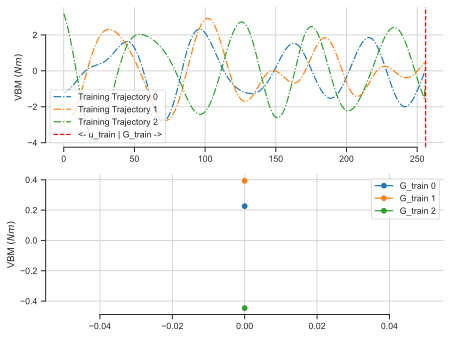

cur_mode:8/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


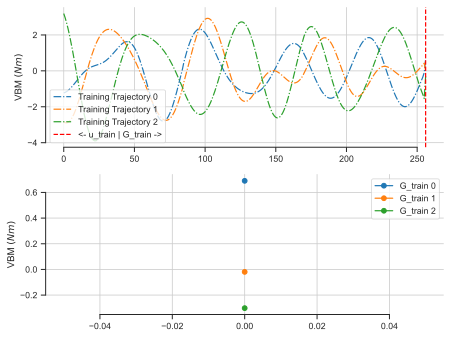

cur_mode:9/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


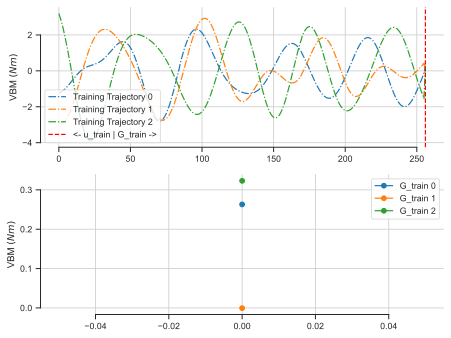

cur_mode:0/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


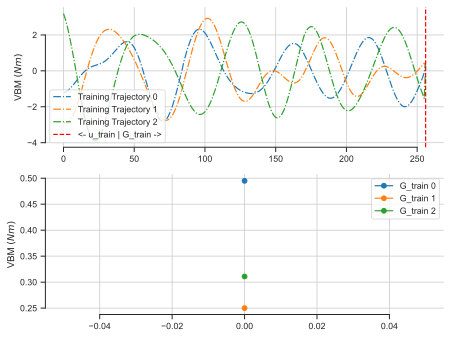

cur_mode:1/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


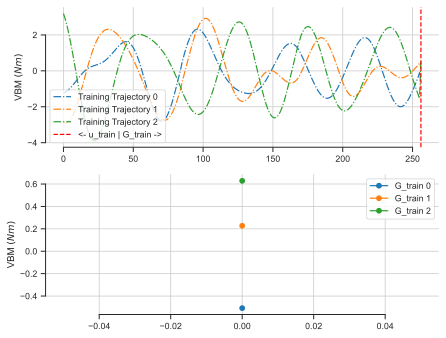

cur_mode:2/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


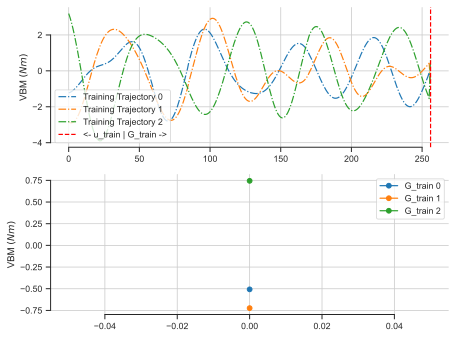

cur_mode:3/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


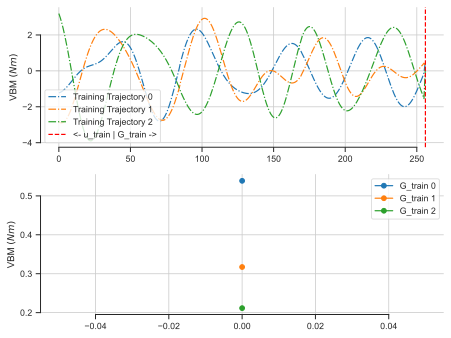

cur_mode:4/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


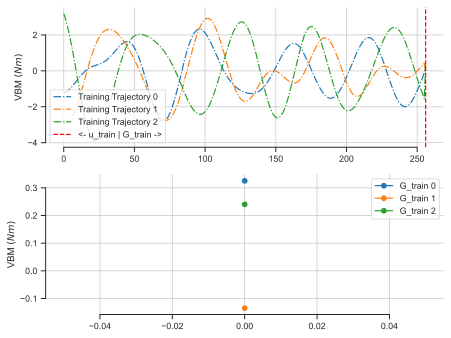

cur_mode:5/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


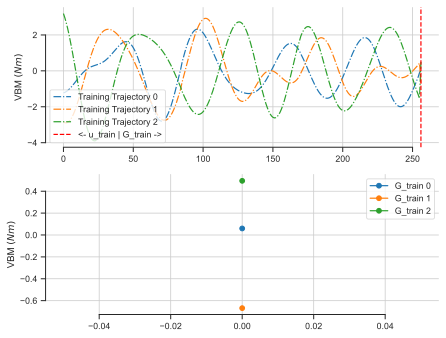

cur_mode:6/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


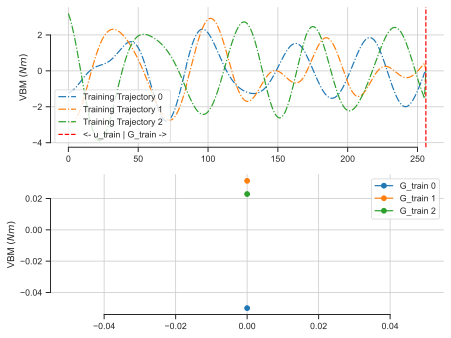

cur_mode:7/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


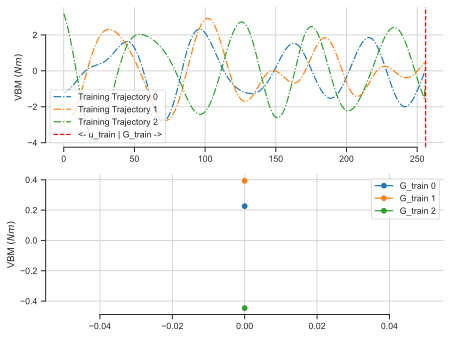

cur_mode:8/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


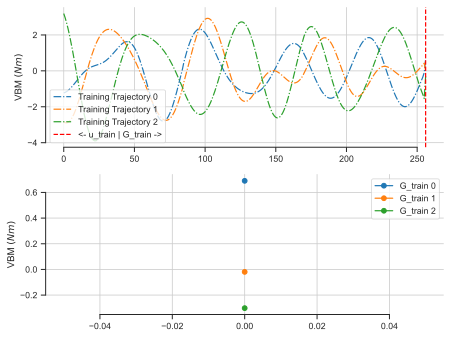

cur_mode:9/n_q_modes:10
Shape of u_train:(3, 256)
Shape of y_train:(3, 1)
Shape of G_train:(3, 1)


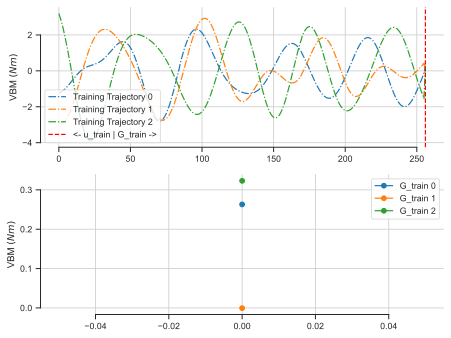

In [10]:
from supervisor.supervisor import DeepXDE_DeepONet

for iter_num in range(initial_iter_num,initial_iter_num+iters_max):

        for cur_mode in range(0, n_q_modes) :
            print(f"cur_mode:{cur_mode}/n_q_modes:{n_q_modes}")
        
            # Setup the data using current round robin index
            cur_Y = Y[:, cur_mode]
            cur_Y = np.reshape(cur_Y, [cur_Y.shape[0], 1])
            
            # Train the model
            np.random.seed(np.size(Y))
            
            model_str = '_r{}'.format(cur_mode)
            model = DeepXDE_DeepONet(Theta, n_wave_t, cur_Y, net, 
                                     lr, epochs, N, model_dir, seed, save_period, model_str, 
                                     coarse, udim, wDD,wVV,u_decimation_factor, make_plots=True)

## DeepXDE Training

In [11]:
from supervisor.supervisor import DeepXDE_DeepONet

for iter_num in range(initial_iter_num,initial_iter_num+iters_max):
        model_list = np.empty([n_q_modes,],dtype=object)
    
        # Train a NN for each mode separately, using the particular model coefficients as the NN output
        print('Starting NN training.')

        for cur_mode in range(0, n_q_modes) :
            print(f"cur_mode:{cur_mode}/n_q_modes:{n_q_modes}")
        
            # Setup the data using current round robin index
            cur_Y = Y[:, cur_mode]
            cur_Y = np.reshape(cur_Y, [cur_Y.shape[0], 1])
            
            # Train the model
            np.random.seed(np.size(Y))
            
            model_str = '_r{}'.format(cur_mode)
            model = DeepXDE_DeepONet(Theta, n_wave_t, cur_Y, net, 
                                     lr, epochs, N, model_dir, seed, save_period, model_str, 
                                     coarse, udim, wDD,wVV,u_decimation_factor)
            
            model_list[cur_mode] = model
            
            # Create the set of test points
            # NEW: Check the parameters of the precomputed LHS points
            # Theta_test = vAAlhs

            # Evaluate the model for Active Sampling!
            # Save values outside of the loop that we might need later
            # (for diagnostic plots, mostly)
            # print('Starting acquisition function evaluations for Active Sampling.')
            # if as_target_quantity == 'mode-coefficient' :
            #     ax_list = np.empty([n_q_modes,],dtype=object)
            #     cur_q_index = np.mod(iter_num, rr_constant)
            #     cur_extrema_class = 'none'
                
            #     for cur_mode in range(0, n_q_modes) :
                
            #         Mean_Val, Var_Val, wx, ax, py, py_standard, x_int, x_int_standard = hf.acq_calculation_rom(model_list, 
            #                                                     Theta_test, inputs, qq_xx=qq_xx, acq_rule=acq,
            #                                                     cur_mode=cur_mode, as_target_quantity='mode-coefficient', n_q_modes=n_q_modes,
            #                                                     v_vbm=v_vbm, w_vbm=w_vbm, vv_var=vv_var)
            #         ax_list[cur_mode] = ax
                    
            #     ax_cur = ax_list[cur_q_index]


Starting NN training.
cur_mode:0/n_q_modes:10
Compiling model...
'compile' took 4.008892 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.15e-01]    [2.84e-01]    [2.84e-01]    
1000      [7.10e-15]    [3.55e-15]    [3.55e-15]    

Best model at step 1000:
  train loss: 7.10e-15
  test loss: 3.55e-15
  test metric: [3.55e-15]

'train' took 12.696047 s

Compiling model...
'compile' took 0.005712 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.10e-15]    [3.55e-15]    [3.55e-15]    
1000      [1.36e-15]    [3.55e-15]    [3.55e-15]    

Best model at step 1000:
  train loss: 1.36e-15
  test loss: 3.55e-15
  test metric: [3.55e-15]

'train' took 12.929747 s

cur_mode:1/n_q_modes:10
Compiling model...
'compile' took 0.000435 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [3.69e-01]    [1.01e+00]    [1.01e+00]    
1000      [5.06e-07]    [9.61e-12]    [9.61e-12]    

Best mode

: 

# DeepONet Setup

* For increased speed, we also reduce the sensor number of $x_m$ sensors 1024 points for the LAMP wave episode.
* In addition to the hyperparameters, we use the ReLu activation function, a learning rate of lr = 0.001, and 1000 epochs for each training procedure. 
* For the LAMP search, the same hyperparameters are used with 5 branch layers, 1 redundant trunk layer, and 200 neurons.

### Implementation tips
1. The input function to the DNO should be scaled to vary within values of -1 and 1.
2. The quantity of interest, or output, should also be scaled and normalized to values between -1 and 1.
3. Users should ensure that the DNO is indeed fitting the outputs. This is typically observed with final training errors that are multiple orders of magnitude below the initial training error at epoch 0. To adjust, increase training epochs, layers, and/or width of neurons. Otherwise, the scaling above may have not been appropriately performed.

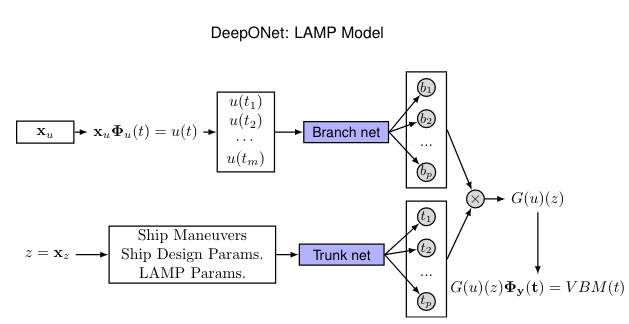

In [1]:
%matplotlib inline
from IPython.display import Image
Image('./DeepONet-LAMP Model.png')